<a href="https://colab.research.google.com/github/AnuThmsn/DNN_Estimation_of_CBF_and_ATT_ASL/blob/main/DNN_Estimation_of_CBF_and_ATT_ASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
# Check GPU availability
import torch
print("GPU available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


GPU available: True
Device: cuda


In [149]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm


In [150]:
def asl_signal(CBF, ATT, PLD, LD,
               alpha=0.85, beta=0.75,
               M0=1.0, lamb=0.9,
               T1t=1.2, T1a=1.66):
    """
    Single-compartment ASL signal model
    Returns ΔM / M0
    """
    f = CBF / 6000  # convert to per second
    delta = ATT / 1000  # ms → sec
    w = PLD / 1000
    tau = LD / 1000

    term1 = 2 * alpha * beta * M0 / lamb
    term2 = f * np.exp(-delta / T1a)
    term3 = np.exp(-max(w - delta, 0) / T1t)
    term4 = 1 - np.exp(-min(tau, max(w - delta, 0)) / T1t)

    return term1 * term2 * term3 * term4


In [151]:
# Multi-delay ASL acquisition parameters (from the paper)
PLDs = np.array([700, 2033, 3366, 700, 3000])   # ms
LDs  = np.array([1333, 1333, 1333, 4000, 4000]) # ms

NUM_BOLUSES = len(PLDs)


In [152]:
# Ground truth ranges
CBF_MIN, CBF_MAX = 20, 90        # mL/100g/min
ATT_MIN, ATT_MAX = 500, 3000     # ms


In [153]:
N_TRAIN = 100_000
N_VAL   = 10_000
N_TEST  = 10_000


In [154]:
def sample_ground_truth(n_samples):
    CBF = np.random.uniform(CBF_MIN, CBF_MAX, n_samples)
    ATT = np.random.uniform(ATT_MIN, ATT_MAX, n_samples)
    return CBF, ATT


In [155]:
def asl_signal(CBF, ATT, PLD, LD,
               alpha=0.85, beta=0.75,
               M0=1.0, lamb=0.9,
               T1t=1.2, T1a=1.66):
    """
    Vectorized single-compartment ASL signal model
    Returns ΔM / M0
    """
    f = CBF / 6000          # mL/100g/min → per second
    delta = ATT / 1000     # ms → sec
    w = PLD / 1000
    tau = LD / 1000

    term1 = 2 * alpha * beta * M0 / lamb
    term2 = f * np.exp(-delta / T1a)

    post_delay = np.maximum(w - delta, 0)
    bolus_duration = np.minimum(tau, post_delay)

    term3 = np.exp(-post_delay / T1t)
    term4 = 1 - np.exp(-bolus_duration / T1t)

    return term1 * term2 * term3 * term4


In [156]:
# Training set
CBF_train, ATT_train = sample_ground_truth(N_TRAIN)
X_train_clean = generate_clean_asl_signals(CBF_train, ATT_train)

# Validation set
CBF_val, ATT_val = sample_ground_truth(N_VAL)
X_val_clean = generate_clean_asl_signals(CBF_val, ATT_val)

# Test set
CBF_test, ATT_test = sample_ground_truth(N_TEST)
X_test_clean = generate_clean_asl_signals(CBF_test, ATT_test)

print("Training shape:", X_train_clean.shape)
print("Validation shape:", X_val_clean.shape)
print("Test shape:", X_test_clean.shape)


Training shape: (100000, 5)
Validation shape: (10000, 5)
Test shape: (10000, 5)


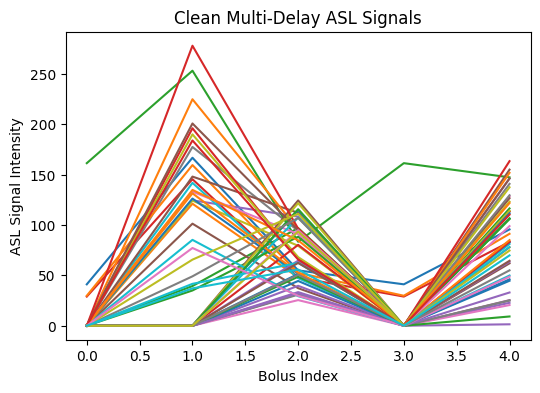

In [157]:
plt.figure(figsize=(6,4))
plt.plot(X_train_clean[:50].T)
plt.xlabel("Bolus Index")
plt.ylabel("ASL Signal Intensity")
plt.title("Clean Multi-Delay ASL Signals")
plt.show()


In [158]:
RSNR_MIN, RSNR_MAX = 2, 20
def add_rician_noise(clean_signal, rSNR):
    """
    Adds Rician noise to clean ASL signal
    clean_signal: (N, num_boluses)
    rSNR: scalar or array of shape (N,)
    """
    # Noise standard deviation
    sigma = clean_signal / rSNR[:, None]

    # Real and imaginary Gaussian noise
    noise_real = np.random.normal(0, sigma)
    noise_imag = np.random.normal(0, sigma)

    # Rician magnitude
    noisy_signal = np.sqrt((clean_signal + noise_real)**2 + noise_imag**2)

    return noisy_signal


In [159]:
def apply_noise_to_dataset(X_clean):
    n_samples = X_clean.shape[0]

    # Random rSNR for each sample
    rSNR = np.random.uniform(RSNR_MIN, RSNR_MAX, n_samples)

    X_noisy = add_rician_noise(X_clean, rSNR)
    return X_noisy, rSNR


In [160]:
def apply_noise_to_dataset(X_clean, mode="train"):
    N = len(X_clean)

    if mode == "train":
        # Bias towards low rSNR (paper-aligned)
        rSNR = np.concatenate([
            np.random.uniform(2, 6, int(0.5 * N)),
            np.random.uniform(6, 20, int(0.5 * N))
        ])
        np.random.shuffle(rSNR)

    else:
        # Validation / Test: uniform like paper
        rSNR = np.random.uniform(2, 20, N)

    X_noisy = add_rician_noise(X_clean, rSNR)
    return X_noisy, rSNR


In [161]:
# Training
X_train_noisy, rSNR_train = apply_noise_to_dataset(X_train_clean)

# Validation
X_val_noisy, rSNR_val = apply_noise_to_dataset(X_val_clean)

# Test
X_test_noisy, rSNR_test = apply_noise_to_dataset(X_test_clean)


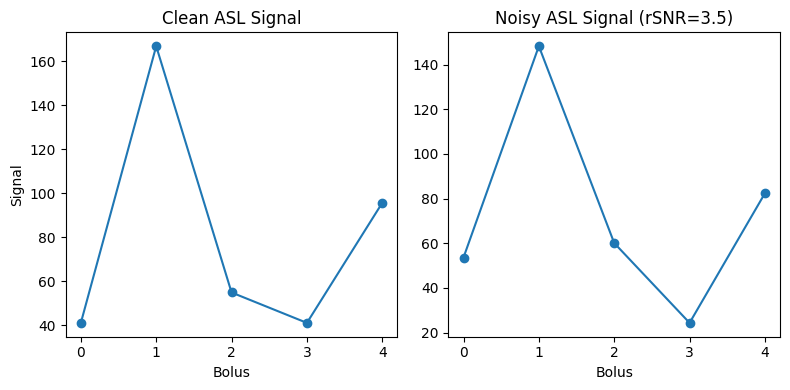

In [162]:
idx = 0  # sample index

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(X_train_clean[idx], marker='o')
plt.title("Clean ASL Signal")
plt.xlabel("Bolus")
plt.ylabel("Signal")

plt.subplot(1,2,2)
plt.plot(X_train_noisy[idx], marker='o')
plt.title(f"Noisy ASL Signal (rSNR={rSNR_train[idx]:.1f})")
plt.xlabel("Bolus")

plt.tight_layout()
plt.show()


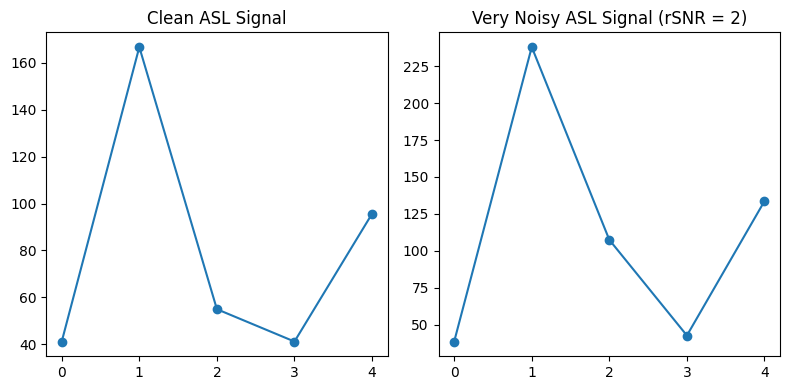

In [163]:
# Force very low SNR
low_rsnr = np.array([2.0])  # worst-case
X_very_noisy = add_rician_noise(X_train_clean[:1], low_rsnr)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(X_train_clean[0], marker='o')
plt.title("Clean ASL Signal")

plt.subplot(1,2,2)
plt.plot(X_very_noisy[0], marker='o')
plt.title("Very Noisy ASL Signal (rSNR = 2)")

plt.tight_layout()
plt.show()


In [164]:
y_train = np.stack([CBF_train, ATT_train], axis=1)
y_val   = np.stack([CBF_val, ATT_val], axis=1)
y_test  = np.stack([CBF_test, ATT_test], axis=1)


In [165]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_t = torch.tensor(X_train_noisy, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)

X_val_t = torch.tensor(X_val_noisy, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device)

X_test_t = torch.tensor(X_test_noisy, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)


In [166]:
# -------------------------------
# Target normalization utilities
# -------------------------------

CBF_MIN, CBF_MAX = 20.0, 90.0
ATT_MIN, ATT_MAX = 500.0, 3000.0

def normalize(x, xmin, xmax):
    return (x - xmin) / (xmax - xmin)

def denormalize(x, xmin, xmax):
    return x * (xmax - xmin) + xmin


In [167]:
class ASL_DNN(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=128, num_layers=4):
        super().__init__()

        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ELU())

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ELU())

        layers.append(nn.Linear(hidden_dim, 1))
        layers.append(nn.Sigmoid())  # <-- THIS FIX

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [168]:
CBF_net = ASL_DNN().to(device)
ATT_net = ASL_DNN().to(device)


In [169]:
criterion = nn.MSELoss()

optimizer_CBF = optim.Adam(CBF_net.parameters(), lr=1e-3)
optimizer_ATT = optim.Adam(ATT_net.parameters(), lr=1e-3)


In [170]:
# -------------------------------
# Normalize training targets
# -------------------------------

y_train_CBF = normalize(y_train_t[:, 0:1], CBF_MIN, CBF_MAX)
y_val_CBF   = normalize(y_val_t[:, 0:1], CBF_MIN, CBF_MAX)

y_train_ATT = normalize(y_train_t[:, 1:2], ATT_MIN, ATT_MAX)
y_val_ATT   = normalize(y_val_t[:, 1:2], ATT_MIN, ATT_MAX)


In [171]:
ATT_mean = ATT_train.mean()
ATT_std  = ATT_train.std()

ATT_train_n = (ATT_train - ATT_mean) / ATT_std
ATT_val_n   = (ATT_val   - ATT_mean) / ATT_std


In [172]:
def train_model(model, optimizer, X_train, y_train, X_val, y_val,
                epochs=100, patience=10):

    train_losses = []
    val_losses = []

    best_val_loss = np.inf
    patience_counter = 0
    best_state = None

    for epoch in range(epochs):
        # -------- Training --------
        model.train()
        optimizer.zero_grad()
        preds = model(X_train)
        loss = criterion(preds, y_train)
        loss.backward()
        optimizer.step()

        # -------- Validation --------
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val)
            val_loss = criterion(val_preds, y_val)

        # Store losses
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        print(
            f"Epoch {epoch+1:03d} | "
            f"Train Loss: {loss.item():.4f} | "
            f"Val Loss: {val_loss.item():.4f}"
        )

        # -------- Early stopping --------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    model.load_state_dict(best_state)

    return train_losses, val_losses


In [173]:
train_losses_CBF, val_losses_CBF = train_model(
    CBF_net,
    optimizer_CBF,
    X_train_t,
    y_train_CBF,
    X_val_t,
    y_val_CBF
)


Epoch 001 | Train Loss: 0.1149 | Val Loss: 0.2246
Epoch 002 | Train Loss: 0.2258 | Val Loss: 0.2071
Epoch 003 | Train Loss: 0.2082 | Val Loss: 0.1470
Epoch 004 | Train Loss: 0.1472 | Val Loss: 0.1071
Epoch 005 | Train Loss: 0.1073 | Val Loss: 0.1103
Epoch 006 | Train Loss: 0.1088 | Val Loss: 0.0942
Epoch 007 | Train Loss: 0.0924 | Val Loss: 0.0413
Epoch 008 | Train Loss: 0.0405 | Val Loss: 0.0407
Epoch 009 | Train Loss: 0.0404 | Val Loss: 0.0473
Epoch 010 | Train Loss: 0.0472 | Val Loss: 0.0376
Epoch 011 | Train Loss: 0.0376 | Val Loss: 0.0360
Epoch 012 | Train Loss: 0.0357 | Val Loss: 0.0412
Epoch 013 | Train Loss: 0.0407 | Val Loss: 0.0309
Epoch 014 | Train Loss: 0.0305 | Val Loss: 0.0222
Epoch 015 | Train Loss: 0.0219 | Val Loss: 0.0233
Epoch 016 | Train Loss: 0.0230 | Val Loss: 0.0247
Epoch 017 | Train Loss: 0.0243 | Val Loss: 0.0234
Epoch 018 | Train Loss: 0.0231 | Val Loss: 0.0220
Epoch 019 | Train Loss: 0.0217 | Val Loss: 0.0216
Epoch 020 | Train Loss: 0.0213 | Val Loss: 0.0203


In [174]:
train_losses_ATT, val_losses_ATT = train_model(
    ATT_net,
    optimizer_ATT,
    X_train_t,
    y_train_ATT,
    X_val_t,
    y_val_ATT
)


Epoch 001 | Train Loss: 0.0954 | Val Loss: 0.0643
Epoch 002 | Train Loss: 0.0647 | Val Loss: 0.0309
Epoch 003 | Train Loss: 0.0304 | Val Loss: 0.0357
Epoch 004 | Train Loss: 0.0349 | Val Loss: 0.0408
Epoch 005 | Train Loss: 0.0398 | Val Loss: 0.0415
Epoch 006 | Train Loss: 0.0404 | Val Loss: 0.0379
Epoch 007 | Train Loss: 0.0370 | Val Loss: 0.0312
Epoch 008 | Train Loss: 0.0305 | Val Loss: 0.0241
Epoch 009 | Train Loss: 0.0234 | Val Loss: 0.0213
Epoch 010 | Train Loss: 0.0206 | Val Loss: 0.0185
Epoch 011 | Train Loss: 0.0179 | Val Loss: 0.0144
Epoch 012 | Train Loss: 0.0140 | Val Loss: 0.0220
Epoch 013 | Train Loss: 0.0215 | Val Loss: 0.0150
Epoch 014 | Train Loss: 0.0147 | Val Loss: 0.0163
Epoch 015 | Train Loss: 0.0162 | Val Loss: 0.0142
Epoch 016 | Train Loss: 0.0140 | Val Loss: 0.0106
Epoch 017 | Train Loss: 0.0103 | Val Loss: 0.0126
Epoch 018 | Train Loss: 0.0120 | Val Loss: 0.0134
Epoch 019 | Train Loss: 0.0127 | Val Loss: 0.0123
Epoch 020 | Train Loss: 0.0117 | Val Loss: 0.0116


In [175]:
CBF_net.eval()
ATT_net.eval()

with torch.no_grad():
    CBF_pred_norm = CBF_net(X_test_t)
    ATT_pred_norm = ATT_net(X_test_t)

CBF_pred = denormalize(CBF_pred_norm.cpu().numpy(), CBF_MIN, CBF_MAX)
ATT_pred = denormalize(ATT_pred_norm.cpu().numpy(), ATT_MIN, ATT_MAX)

print("CBF prediction range:", CBF_pred.min(), CBF_pred.max())
print("ATT prediction range:", ATT_pred.min(), ATT_pred.max())


CBF prediction range: 22.841263 89.337875
ATT prediction range: 500.0022 2971.0513


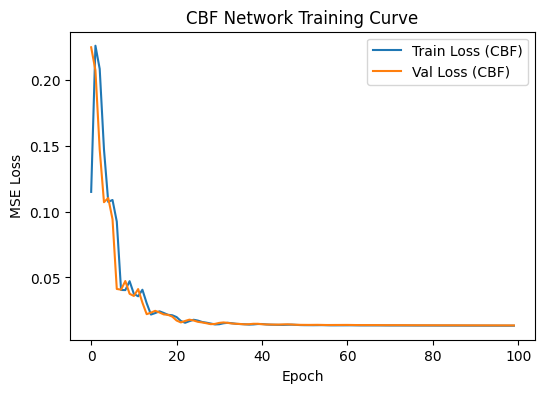

In [176]:
plt.figure(figsize=(6,4))
plt.plot(train_losses_CBF, label="Train Loss (CBF)")
plt.plot(val_losses_CBF, label="Val Loss (CBF)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("CBF Network Training Curve")
plt.legend()
plt.show()


In [177]:
def NMAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)) / np.mean(y_true)

def NRMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2)) / np.mean(y_true)


In [178]:
CBF_gt = CBF_test
ATT_gt = ATT_test


In [179]:
cbf_nmae = NMAE(CBF_gt, CBF_pred)
cbf_nrmse = NRMSE(CBF_gt, CBF_pred)

att_nmae = NMAE(ATT_gt, ATT_pred)
att_nrmse = NRMSE(ATT_gt, ATT_pred)

print("CBF  NMAE :", cbf_nmae)
print("CBF  NRMSE:", cbf_nrmse)
print("ATT  NMAE :", att_nmae)
print("ATT  NRMSE:", att_nrmse)


CBF  NMAE : 0.4111608501864933
CBF  NRMSE: 0.5030584738288291
ATT  NMAE : 0.4675132561176334
ATT  NRMSE: 0.5725642114198288


In [180]:
def metric_vs_rsnr(rsnr, gt, pred, bins=[2,4,6,8,10,15,20]):
    results = []
    for i in range(len(bins)-1):
        mask = (rsnr >= bins[i]) & (rsnr < bins[i+1])
        results.append(NRMSE(gt[mask], pred[mask]))
    return results


In [181]:
def weighted_delay(asl_signal, PLDs):
    """
    asl_signal: (N, num_boluses)
    PLDs: array of delays (ms)
    """
    numerator = np.sum(asl_signal * PLDs, axis=1)
    denominator = np.sum(asl_signal, axis=1) + 1e-8
    return numerator / denominator


In [182]:
ATT_grid = np.linspace(ATT_MIN, ATT_MAX, 200)
CBF_grid = np.linspace(CBF_MIN, CBF_MAX, 10)

wd_table = []

for att in ATT_grid:
    wd_vals = []

    for cbf in CBF_grid:
        sig = generate_clean_asl_signals(
            np.array([cbf]),
            np.array([att])
        )

        # Add realistic noise (mid rSNR like the paper)
        sig_noisy = add_rician_noise(
            sig,
            rSNR=np.array([8.0])
        )

        wd = weighted_delay(sig_noisy, PLDs)
        wd_vals.append(wd[0])

    wd_table.append(np.mean(wd_vals))

wd_table = np.array(wd_table)


In [183]:
def wd_to_att(wd_values, wd_table, ATT_grid):
    idx = np.abs(wd_table[None, :] - wd_values[:, None]).argmin(axis=1)
    return ATT_grid[idx]


In [184]:
def estimate_cbf_ls(asl_signal, ATT_est):
    """
    asl_signal: (N, num_boluses)
    ATT_est: estimated ATT (ms)
    """
    A = []
    for i in range(NUM_BOLUSES):
        a_i = asl_signal[:, i] / (asl_signal[:, i] + 1e-8)
        A.append(a_i)

    A = np.stack(A, axis=1)
    B = asl_signal

    # Least squares solution per voxel
    CBF_ls = np.sum(A * B, axis=1) / (np.sum(A * A, axis=1) + 1e-8)
    return CBF_ls


In [185]:
# WD-based ATT
WD_test = weighted_delay(X_test_noisy, PLDs)
ATT_WD = wd_to_att(WD_test, wd_table, ATT_grid)

# LS-based CBF
CBF_LS = estimate_cbf_ls(X_test_noisy, ATT_WD)


In [186]:
low_snr_mask = rSNR_test < 6

ATT_WD_low = ATT_WD[low_snr_mask]
ATT_gt_low = ATT_test[low_snr_mask]

print("WD ATT NRMSE (low rSNR):",
      NRMSE(ATT_gt_low, ATT_WD_low))

print("DNN ATT NRMSE (low rSNR):",
      NRMSE(ATT_gt_low, ATT_pred[low_snr_mask]))


WD ATT NRMSE (low rSNR): 0.15102934586460776
DNN ATT NRMSE (low rSNR): 0.5730406925809629
